# Sourcepredict example3: Segregating patients with or without *Clostridium difficile* infection (CDI) on the basis of 16s microbiome

Source Article: Domestic canines do not display evidence of gut microbial dysbiosis in the presence of Clostridioides (Clostridium) difficile, despite cellular susceptibility to its toxins [10.1016/j.anaerobe.2019.03.017](https://doi.org/10.1016/j.anaerobe.2019.03.017)

Healthy human dataset: [PRJNA386260](https://www.ebi.ac.uk/ena/data/view/PRJNA386260)  
CDI human dataset: [PRJNA307992](https://www.ebi.ac.uk/ena/data/view/PRJNA307992)

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from ete3 import NCBITaxa
import multiprocessing
from functools import partial
import seaborn as sns

In [2]:
ncbi = NCBITaxa()

## Downloading data

In [3]:
cdi_color = "#E7CE1A"
healthy_color = "white"

In [4]:
tax_level = ['genus','species']

In [5]:
import multiprocessing
import subprocess

def dl(file, outdir):
    cmd = f"wget {file} -P {outdir}"
    print(cmd)
    try:
        subprocess.check_output(cmd, shell=True)
    except subprocess.CalledProcessError:
        print(f"Error downloading {file}")


def dl_multi(allfiles, outdir, process):    
    dl_fun = partial(dl, outdir=outdir)
    with multiprocessing.Pool(process) as p:
        p.map(dl_fun, allfiles)

In [6]:
healthy_meta = pd.read_csv("healthy/PRJNA386260_metadata.txt", sep="\t", index_col='run_accession')
CDI_meta = pd.read_csv("CDI/PRJNA307992_metadata.txt", sep="\t", index_col='run_accession')

In [7]:
healthy_meta['labels'] = ['healthy']*healthy_meta.shape[0]
CDI_meta['labels'] = ['CDI']*CDI_meta.shape[0]

In [8]:
healthy_fastqs = list(healthy_meta['fastq_ftp'].str.split(";", expand=True)[0]) + list(healthy_meta['fastq_ftp'].str.split(";", expand=True)[1])

In [9]:
CDI_fastqs = list(CDI_meta['fastq_ftp'].str.split(";", expand=True)[0]) + list(CDI_meta['fastq_ftp'].str.split(";", expand=True)[1])

Uncomment to download files

In [10]:
#dl_multi(allfiles=healthy_fastqs, outdir="./healthy/", process=4)
#dl_multi(allfiles=CDI_fastqs, outdir="./CDI/", process=4)

### Utility functions

Removing outlier samples (less than 10 species) and species present in less than 10 samples

In [11]:
def remove_outlier(df, n=10):
    return(df.loc[df.nunique(axis=1) > n, df.nunique(axis=0) > n])

Removing TAXID not in NCBI taxonomy

In [12]:
def remove_not_taxo(df):
    """
    df(pandas DataFrame) with TAXID in index, and samples in columns
    """
    valid_ranks = {k:v for (k,v) in zip(ncbi.get_rank(df.index).keys(), ncbi.get_rank(df.index).values()) if v != 'no rank'}
    return(df.loc[valid_ranks.keys(),:])

Normalization methods

In [13]:
def gmpr_size_factor(col, ar):
    """Generate GMPR size factor
    Args:
        col (int): columm index of the numpy array
        ar (numpy array): numpy array of TAXID counts,
            colums as Samples, Rows as TAXIDs
    Returns:
        float: GMPR size factor per column
    """
    pr = np.apply_along_axis(lambda x: np.divide(ar[:, col], x), 0, ar)
    pr[np.isinf(pr)] = np.nan
    pr[pr == 0] = np.nan
    pr_median = np.nanmedian(pr, axis=0)
    return(np.exp(np.mean(np.log(pr_median))))


def GMPR_normalize(df, process=4):
    """Compute GMPR normalization
    Global Mean of Pairwise Ratios
    Chen, L., Reeve, J., Zhang, L., Huang, S., Wang, X., & Chen, J. (2018). 
    GMPR: A robust normalization method for zero-inflated count data 
    with application to microbiome sequencing data. 
    PeerJ, 6, e4600.
    Args:
        df (pandas Dataframe): TAXID count dataframe,
            colums as Samples, Rows as TAXIDs
        process (int): number of process for parallelization
    """
    ar = np.asarray(df)

    gmpr_sf_partial = partial(gmpr_size_factor, ar=ar)
    with multiprocessing.Pool(process) as p:
        sf = p.map(gmpr_sf_partial, list(range(np.shape(ar)[1])))

    return(pd.DataFrame(np.divide(ar, sf), index=df.index, columns=df.columns))

In [14]:
def RLE_normalize(pd_dataframe):
    """Normalize with Relative Log Expression
    Args:
        pd_dataframe (pandas DataFrame): TAXID count dataframe,
            colums as Samples, Rows as TAXIDs
    Returns:
        pandas DataFrame: RLE Normalized datafrane. Colums as Samples, Rows as TAXIDs
    Example:
        >>> RLE_normalize(pd.DataFrame)
    """

    step1 = pd_dataframe.apply(np.log, 0)
    step2 = step1.apply(np.average, 1)
    step3 = step2[step2.replace([np.inf, -np.inf], np.nan).notnull()]
    step4_1 = step1[step1.replace(
        [np.inf, -np.inf], np.nan).notnull().all(axis=1)]
    step4 = step4_1.subtract(step3, 0)
    step5 = step4.apply(np.median, 0)
    step6 = step5.apply(np.exp)
    step7 = pd_dataframe.divide(step6, 1).apply(round, 1)
    return(step7)

In [15]:
def subsample_normalize_pd(pd_dataframe):
    """Normalize with Subsampling
    Args:
        pd_dataframe (pandas DataFrame): TAXID count dataframe,
            colums as Samples, Rows as TAXIDs
    Returns:
       pandas DataFrame: Subsample Normalized dataframe. Colums as Samples, Rows as TAXIDs
    """

    def subsample_normalize(serie, omax):
        """Subsample normalization column wise
        imin: minimum of input range
        imax: maximum of input range
        omin: minimum of output range
        omax: maximum of output range
        x in [imin, imax]
        f(x) in [omin, omax]
                 x - imin
        f(x) = ------------ x(omax - omin) + omin
               imax - imin
        Args:
            serie (pandas Series): Indivudal Sample Column
            omax (int): maximum of output range
        Returns:
            pandas Series: normalized pandas Series
        """

        imin = min(serie)
        imax = max(serie)
        omin = 0
        if imax > 0:
            newserie = serie.apply(lambda x: (
                (x - imin)/(imax - imin)*(omax-omin)+omin))
        else:
            newserie = serie
        return(newserie)

    step1 = pd_dataframe.apply(max, 1)
    themax = max(step1)

    step2 = pd_dataframe.apply(
        subsample_normalize, axis=0, args=(themax,))
    step3 = step2.apply(np.floor, axis=1)
    return(step3)

PLS-DA with sklearn

In [16]:
class plsda:
    def __init__(self, X,Y, labels):
        """
        X(pd DataFrame) normalized feature matrix with samples in index, and features in columns
        Y(np 1D array) binary response variable encoding the grouping for each sample
        labels(named pd Series) of group label for each sample
        """
        from sklearn.cross_decomposition import PLSRegression
        self.plsr = PLSRegression(n_components=2)
        self.plsr.fit(X, Y)
        self.scores = pd.DataFrame(self.plsr.x_scores_, index=X.index, columns=['DIM1','DIM2'])
        self.scores = self.scores.join(labels['labels'])
        self.weights = pd.DataFrame(self.plsr.x_weights_, index=X.columns, columns=['DIM1','DIM2']).sort_values('DIM1', ascending=False)
        self.weights['name'] = ncbi.get_taxid_translator(self.weights.index).values()
        self.top_weights = self.weights.head(20).append(self.weights.tail(20))
        self.top_weights['name'] = pd.Categorical(self.top_weights['name'], categories=self.top_weights['name'])

mds with sklearn

In [17]:
class mds:
    def __init__(self, X, labels, metric='braycurtis'):
        """
        X(pd DataFrame) normalized feature matrix with samples in index, and features in columns
        labels(named pd Series) of group label for each sample
        """
        from sklearn.metrics import pairwise_distances
        from sklearn.manifold import MDS
        dist = pairwise_distances(X, metric=metric)
        self.mds = MDS(n_components=2, dissimilarity='precomputed')
        self.mds.fit(X=dist)
        self.embedding = pd.DataFrame(self.mds.embedding_, columns=['DIM1','DIM2'], index=X.index)
        self.embedding = self.embedding.join(labels)

## Reading the results of the [dada2-nf](https://github.com/maxibor/dada2-nf) pipeline

### 1- Species level

In [18]:
healthy_otu_s = pd.read_csv("/projects1/users/borry/30_dada2-nf/results_healthy/merged/dada2_otu_table.csv", index_col=0)
CDI_otu_s = pd.read_csv("/projects1/users/borry/30_dada2-nf/results_CDI/merged/dada2_otu_table.csv", index_col=0)

In [19]:
healthy_otu_s = healthy_otu_s.drop([0], axis=0)
CDI_otu_s = CDI_otu_s.drop([0], axis=0)

In [20]:
all_otu_s = healthy_otu_s.merge(CDI_otu_s, left_index=True, right_index=True)
all_otu_s = remove_outlier(all_otu_s)
all_otu_s.shape

(103, 305)

In [21]:
all_otu_s.head()

,SRR5578998,SRR5579099,SRR5579045,SRR5578981,SRR5579095,SRR5579054,SRR5578909,SRR5578907,SRR5578965,SRR5579021,...,SRR3102417,SRR3102498,SRR3102362,SRR3102525,SRR3102486,SRR3102556,SRR3102547,SRR3102572,SRR3102515,SRR3102517
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
820,745.0,725.0,973.0,708.0,710.0,507.0,483.0,223.0,43.0,313.0,...,0.0,6319.0,1663.0,0.0,0.0,0.0,0.0,350.0,2235.0,31.0
821,1103.0,742.0,2126.0,0.0,1502.0,1193.0,1316.0,52.0,462.0,947.0,...,0.0,8.0,4899.0,0.0,0.0,0.0,7318.0,833.0,0.0,0.0
824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
851,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,868.0,0.0,0.0,0.0,0.0,0.0,2190.0,0.0,0.0,0.0


### 2- Genus Level

In [22]:
healthy_otu_g = pd.read_csv("/projects1/users/borry/30_dada2-nf/results_healthy_genus/merged/dada2_otu_table.csv", index_col=0)
cdi_otu_g = pd.read_csv("/projects1/users/borry/30_dada2-nf/results_CDI_genus/merged/dada2_otu_table.csv", index_col=0)

In [23]:
healthy_otu_g = healthy_otu_g.drop([0], axis=0)
cdi_otu_g = cdi_otu_g.drop([0], axis=0)

In [24]:
all_otu_g = healthy_otu_g.merge(cdi_otu_g, left_index=True, right_index=True)
all_otu_g = remove_outlier(all_otu_g)
print(all_otu_g.shape)
all_otu_g.head()

(114, 405)


,SRR5578998,SRR5579099,SRR5579045,SRR5578981,SRR5579095,SRR5579054,SRR5578909,SRR5578907,SRR5578965,SRR5579115,...,SRR3102507,SRR3102439,SRR3102474,SRR3102487,SRR3102547,SRR3102572,SRR3102381,SRR3102515,SRR3102405,SRR3102517
194,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
469,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
544,0.0,0.0,1203.0,0.0,0.0,0.0,0.0,182.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalizing dataframes

In [25]:
X_s = subsample_normalize_pd(all_otu_s).T

In [26]:
X_g = GMPR_normalize(all_otu_g, 4).dropna(axis=1).T

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/ipykernel_launcher.py:10: Run

## Creating labels dataframe and response variable array

In [27]:
labels = healthy_meta['labels'].to_frame().append(CDI_meta['labels'].to_frame())

In [28]:
labels_s = labels.loc[X_s.index, :]
Y_s = np.where(labels_s['labels']=='healthy', '1','0')

In [29]:
labels_g = labels.loc[X_g.index, :]
Y_g = np.where(labels_g['labels']=='healthy', '1','0')

## Exploring the dataset

In [30]:
import seaborn as sns

#### 1- Partial Least Square Discriminant Analysis (PLS-DA)
[PLS-DA with Python](https://www.mfitzp.com/article/partial-least-squares-discriminant-analysis-plsda/)

#### Species

In [31]:
plsda_s = plsda(X_s, Y_s, labels_s)

In [32]:
plsda_s.scores

,DIM1,DIM2,labels
SRR5578998,0.935718,0.126756,healthy
SRR5579099,2.614041,0.075360,healthy
SRR5579045,-0.424088,0.029255,healthy
SRR5578981,1.068008,0.688370,healthy
SRR5579095,-0.458098,0.082241,healthy
...,...,...,...
SRR3102556,-5.292148,-2.756433,CDI
SRR3102547,-1.763199,0.052028,CDI
SRR3102572,-1.139385,-1.983172,CDI
SRR3102515,-3.229330,-3.165894,CDI


/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/PLS-DA.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


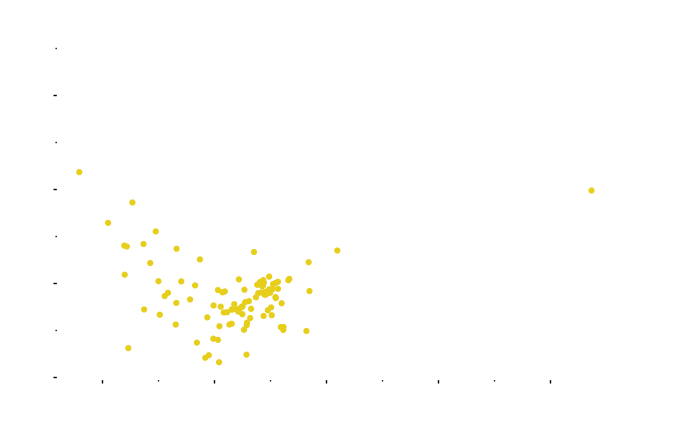

<ggplot: (8783948178096)>

In [33]:
g = ggplot(plsda_s.scores, aes(x='DIM1',y='DIM2', color='labels')) 
g += geom_point() 
g += scale_color_manual(name='Status',values = {"CDI":cdi_color, "healthy":healthy_color})
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/PLS-DA.png', format='png', dpi=300, transparent=True)
g

The separation appears clearly in the first latent variable (DIM1)

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/weight_CDI.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


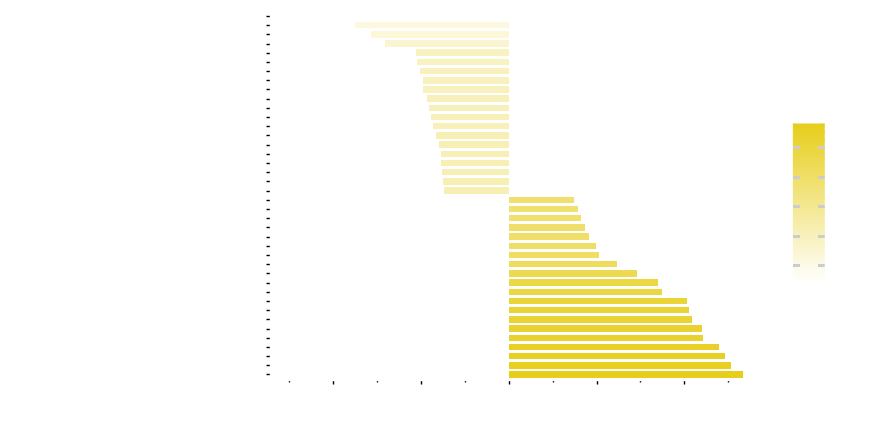

<ggplot: (-9223363252906614854)>

In [34]:
g = ggplot(plsda_s.top_weights, aes(x='name',y='DIM1', fill='DIM1')) 
g += geom_bar(stat='identity', width=0.7) 
g += coord_flip() 
g += scale_fill_gradient(name = 'weight', low=healthy_color, high=cdi_color)
g += xlab('species')
g += ylab('weight in PC1')
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/weight_CDI.png', format='png', dpi=300, transparent=True)
g

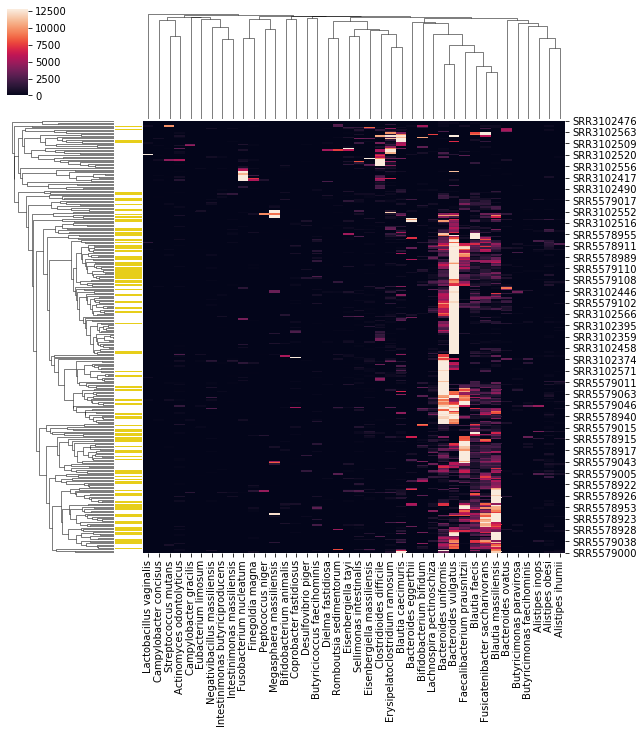

In [35]:
X_s_heatmap = X_s.merge(labels_s, left_index=True, right_index=True).sort_values('labels').drop('labels', axis=1)
X_s_heatmap.columns = ncbi.get_taxid_translator(X_s_heatmap.columns).values()
samp_colors = list(np.where(labels_s['labels'] == 'CDI', cdi_color,healthy_color))
sns.clustermap(X_s_heatmap.loc[:,plsda_s.top_weights['name']], row_colors=samp_colors, metric='braycurtis')

In [36]:
labels_s

,labels
SRR5578998,healthy
SRR5579099,healthy
SRR5579045,healthy
SRR5578981,healthy
SRR5579095,healthy
...,...
SRR3102556,CDI
SRR3102547,CDI
SRR3102572,CDI
SRR3102515,CDI


In [37]:
mds_s = mds(X_s, labels_s['labels'], metric='euclidean')

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/PCoA.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


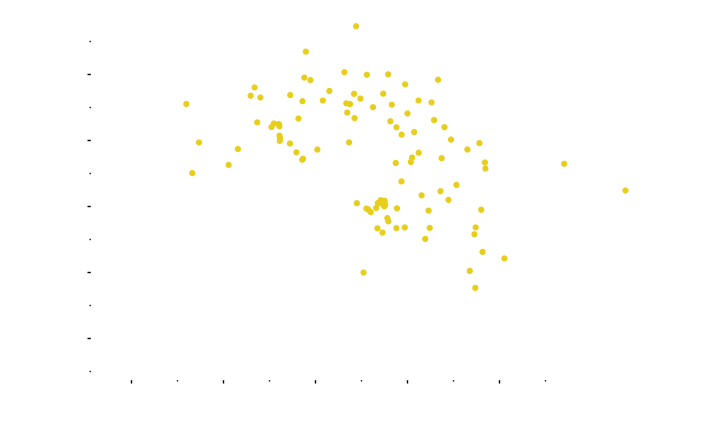

<ggplot: (8783943779760)>

In [38]:
g = ggplot(mds_s.embedding, aes(x='DIM1',y='DIM2', color='labels')) 
g += geom_point() 
g += scale_color_manual(name='Status',values = {"CDI":cdi_color, "healthy":healthy_color})
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/PCoA.png', format='png', dpi=300, transparent=True)
g

#### Genus

In [39]:
plsda_g = plsda(X_g, Y_g, labels_g)

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/PLS-DA_genus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


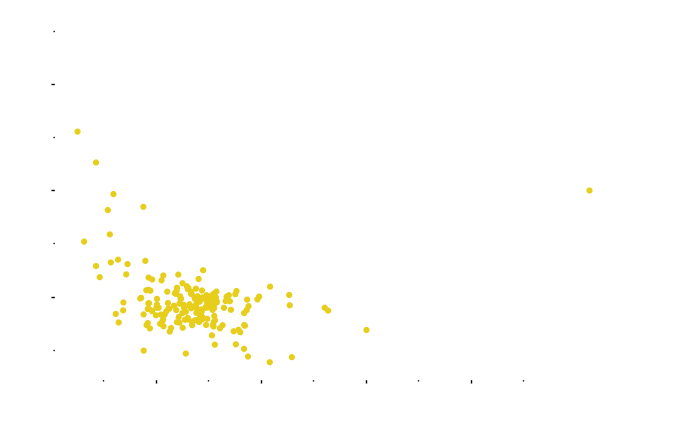

<ggplot: (8783879644550)>

In [40]:
g = ggplot(plsda_g.scores, aes(x='DIM1',y='DIM2', color='labels')) 
g += geom_point() 
g += scale_color_manual(name='Status',values = {"CDI":cdi_color, "healthy":healthy_color})
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/PLS-DA_genus.png', format='png', dpi=300, transparent=True)
g

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/weight_CDI_genus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


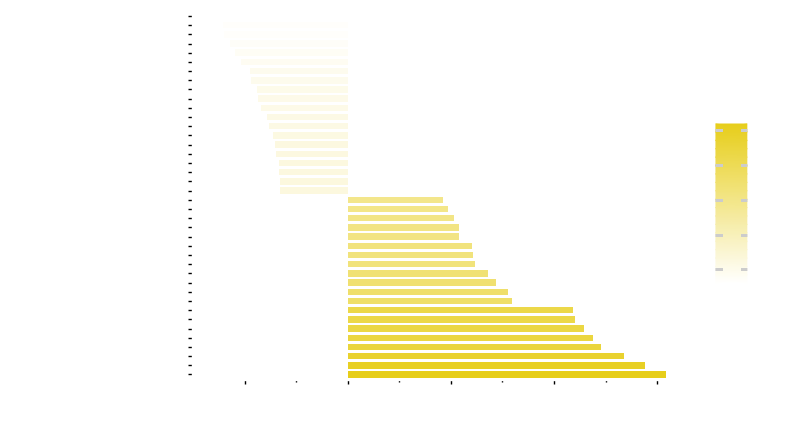

<ggplot: (-9223363252975187859)>

In [41]:
g = ggplot(plsda_g.top_weights, aes(x='name',y='DIM1', fill='DIM1')) 
g += geom_bar(stat='identity', width=0.7) 
g += coord_flip() 
g += scale_fill_gradient(name = 'weight', low=healthy_color, high=cdi_color)
g += xlab('Genus')
g += ylab('weight in PC1')
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color=healthy_color), 
           legend_text=element_text(color=healthy_color, weight='bold'),
          axis_text=element_text(color=healthy_color, weight='bold'),
          axis_title=element_text(color=healthy_color, weight='bold'),
          legend_title=element_text(color=healthy_color, weight='bold'))
g.save('results/weight_CDI_genus.png', format='png', dpi=300, transparent=True)
g

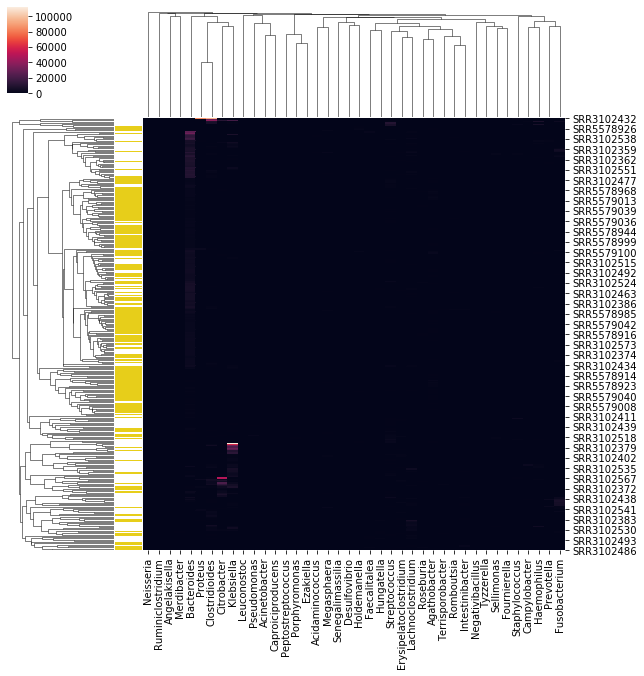

In [42]:
X_g_heatmap = X_g.merge(labels_g, left_index=True, right_index=True).sort_values('labels').drop('labels', axis=1)
X_g_heatmap.columns = ncbi.get_taxid_translator(X_g_heatmap.columns).values()
samp_colors = list(np.where(labels_g['labels'] == 'CDI', cdi_color,healthy_color))
sns.clustermap(X_g_heatmap.loc[:,plsda_g.top_weights['name']], row_colors=samp_colors, metric='braycurtis')

MDS

In [43]:
mds_g = mds(X_g, labels_g)

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/PCoA.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


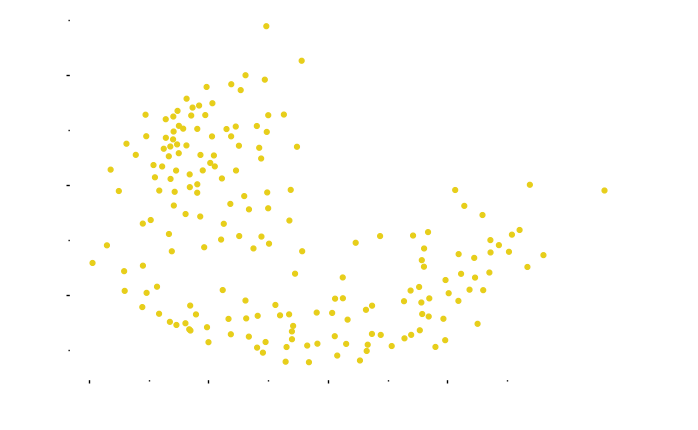

<ggplot: (-9223363252975420700)>

In [44]:
g = ggplot(mds_g.embedding, aes(x='DIM1',y='DIM2', color='labels')) 
g += geom_point() 
g += scale_color_manual(name='Status',values = {"CDI":cdi_color, "healthy":healthy_color})
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/PCoA.png', format='png', dpi=300, transparent=True)
g

### Pre-analysis conclusion:
Based on the clustering (Heatmap) and the MDS, there is a better separation of the two classed at the genus level.

### Preparing data for sourcepredict 

#### on species

In [45]:
train_species = X_s.T.sample(frac=0.8, axis=1, random_state=2)

In [46]:
test_species = X_s.T.drop(train_species.columns, axis=1)

In [47]:
train_labels_species = labels_s.loc[train_species.columns,:]

In [48]:
test_labels_species = labels_s.loc[test_species.columns,:]

In [49]:
train_species.to_csv("source_species.csv")
test_species.to_csv("sink_species.csv")
train_labels_species.to_csv("source_labels_species.csv")
test_labels_species.to_csv("sink_labels_species.csv")

#### on genus

In [50]:
train_genus = X_g.T.sample(frac=0.8, axis=1, random_state=2)

In [51]:
test_genus = X_g.T.drop(train_genus.columns, axis=1)

In [52]:
train_labels_genus = labels_g.loc[train_genus.columns,:]

In [53]:
test_labels_genus = labels_g.loc[test_genus.columns,:]

In [54]:
train_genus.to_csv("source_genus.csv")
test_genus.to_csv("sink_genus.csv")
train_labels_genus.to_csv("source_labels_genus.csv")
test_labels_genus.to_csv("sink_labels_genus.csv")

### Running sourcepredict

#### on species

In [55]:
%%time
! /projects1/users/borry/18_sourcepredict/sourcepredict -s source_species.csv -l source_labels_species.csv sink_species.csv -n None -me tsne -di 2 -t 6 -e embedding_species.csv

Step 1: Checking for unknown proportion
  == Sample: SRR5578937 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5578937
		 known:97.62%
		 unknown:2.38%
  == Sample: SRR5578953 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5578953
		 known:97.62%
		 unknown:2.38%
  == Sample: SRR5578924 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5578924
		 known:97.62%
		 unknown:2.38%
  == Sample: SR

#### on genus

In [56]:
%%time
! /projects1/users/borry/18_sourcepredict/sourcepredict -s source_genus.csv -l source_labels_genus.csv sink_genus.csv -r genus -n None -me tsne -di 2 -dt weighted_unifrac -t 6 -e embedding_genus.csv

Step 1: Checking for unknown proportion
  == Sample: SRR5578953 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5578953
		 known:97.37%
		 unknown:2.63%
  == Sample: SRR5578924 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5578924
		 known:97.37%
		 unknown:2.63%
  == Sample: SRR5579094 ==
	Adding unknown
	Normalizing (no normalization)
	Computing Bray-Curtis distance
	Performing MDS embedding in 2 dimensions
	KNN machine learning
	Training KNN classifier on 6 cores...
	-> Testing Accuracy: 1.0
	----------------------
	- Sample: SRR5579094
		 known:97.37%
		 unknown:2.63%
  == Sample: SR

## Reading Sourcepredict results

In [57]:
from sklearn.metrics import accuracy_score

#### Genus level

In [58]:
pred_genus = pd.read_csv("sink_genus.sourcepredict.csv", index_col=0)
test_labels_genus = pd.read_csv("sink_labels_genus.csv", index_col=0)

In [59]:
conf_table_genus = pred_genus.idxmax(axis=0).to_frame(name='predicted').merge(test_labels_genus, left_index=True, right_index=True)

In [60]:
conf_table_genus = conf_table_genus.dropna()

In [61]:
conf_table_genus.shape

(68, 2)

In [62]:
conf_table_genus.apply(pd.value_counts, axis=0)

,predicted,labels
healthy,38,38
CDI,30,30


In [63]:
acc_genus = accuracy_score(y_true=conf_table_genus['labels'], y_pred=conf_table_genus['predicted'])
print(f"Accuracy: {round(acc_genus,2)}")

Accuracy: 0.94


In [64]:
from plotnine import *

In [65]:
embed = pd.read_csv("embedding_genus.csv", index_col=0)
embed = embed.rename(columns={'labels':'type'})
embed['type'] = embed['type'].str.replace('CDI','source').replace('healthy','source')
embed = embed.join(labels_g['labels']).rename(columns={'labels':'actual'})
embed = embed.join(pd.Series(pred_genus.idxmax(), name='predicted'))

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/train_embedding.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


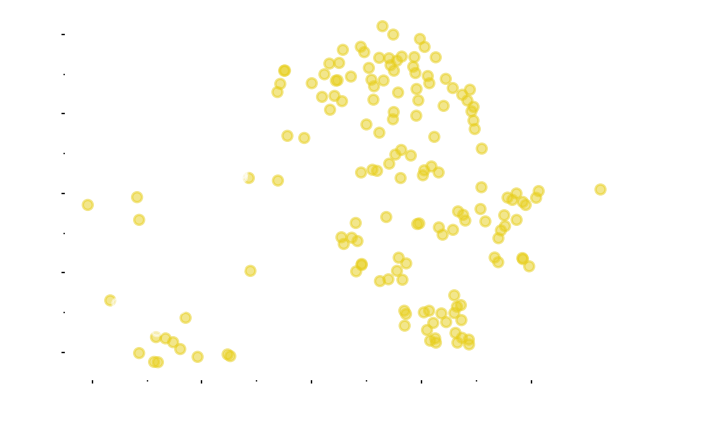

<ggplot: (-9223363252913189530)>

In [66]:
g = ggplot(embed.query("type == 'source'"), aes(x='PC1',y='PC2', color='labels'))
g += geom_point(size=3, stroke=1, alpha=0.5)
g += scale_color_manual(name = 'Reference', values = {"CDI":cdi_color, "healthy":healthy_color})
g += xlab('DIM1')
g += ylab('DIM2')
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color=healthy_color), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/train_embedding.png', format='png', dpi=300, transparent=True)
g

/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/sourcepredict/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/test_embedding.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


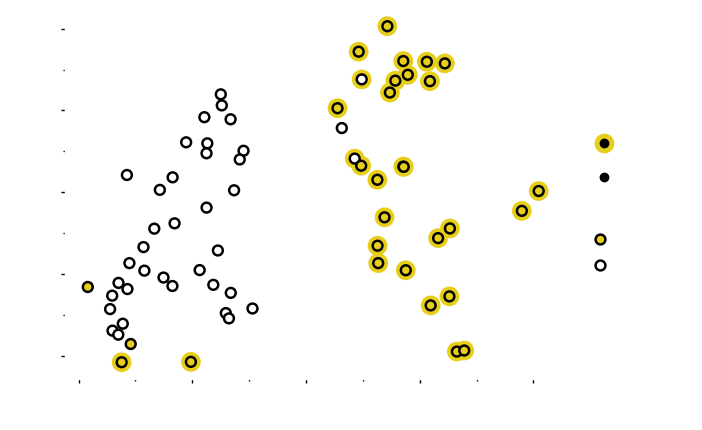

<ggplot: (8783879309772)>

In [67]:
g = ggplot(embed.query("type == 'sink'"), aes(x='PC1',y='PC2', color='predicted'))
g += geom_point(size=4, shape='o', fill = 'black', stroke=2)
g += geom_point(data=embed.query("type == 'sink'"), mapping=aes(x='PC1',y='PC2', fill='actual'), size=3, color='black', stroke=1)
g += scale_color_manual(name = 'Reference', values = {"CDI":cdi_color, "healthy":healthy_color})
g += scale_fill_manual(name = 'Prediction', values = {"CDI":cdi_color, "healthy":healthy_color})
g += xlab('DIM1')
g += ylab('DIM2')
g += theme_classic()
g += theme(plot_background=element_blank(), 
           panel_background=element_blank(), 
           legend_background=element_blank(), 
           axis_line=element_line(color='white'), 
           legend_text=element_text(color='white', weight='bold'),
          axis_text=element_text(color='white', weight='bold'),
          axis_title=element_text(color='white', weight='bold'),
          legend_title=element_text(color='white', weight='bold'))
g.save('results/test_embedding.png', format='png', dpi=300, transparent=True)
g

# Comparing with Sourcetracker 2

Generating the data for Sourcetracker 2

In [68]:
X_g.T.to_csv("st_genus.txt", sep="\t", index_label="TAXID")

test_labels_genus['SourceSink']= ['sink']*test_labels_genus.shape[0]

In [69]:
train_labels_genus['SourceSink'] = ['source']*train_labels_genus.shape[0]

In [70]:
st_metadata = train_labels_genus.append(test_labels_genus).rename(columns = {"labels":"Env"})[['SourceSink','Env']]
st_metadata['SourceSink'][train_labels_genus.index] = ['source']*train_labels_genus.shape[0]
st_metadata['SourceSink'][test_labels_genus.index] = ['sink']*test_labels_genus.shape[0]
st_metadata

,SourceSink,Env
SRR5579101,source,healthy
SRR3102473,source,CDI
SRR3102501,source,CDI
SRR5578964,source,healthy
SRR5579017,source,healthy
...,...,...
SRR3102527,sink,CDI
SRR3102409,sink,CDI
SRR3102362,sink,CDI
SRR3102487,sink,CDI


In [71]:
st_metadata.to_csv("st_genus_metadata.csv", sep="\t", index_label='#SampleID')

### Running sourcetracker

#### Genus level

```
sourcetracker2 gibbs -i st_genus.biom -m st_genus_metadata.csv -o st_genus_out --jobs 6 --source_rarefaction_depth 0 --sink_rarefaction_depth 0
```

Reading sourcetracker results

In [72]:
st_pred = pd.read_csv("st_genus_out/mixing_proportions.txt", sep = "\t", index_col=0)

In [73]:
st2_pred = st_pred.idxmax(axis=1).to_frame(name='predicted').merge(test_labels_genus, left_index=True, right_index=True).rename(columns={'labels':'actual'})

In [74]:
st2_pred.head()

,predicted,actual
SRR5578953,healthy,healthy
SRR5578924,healthy,healthy
SRR5579094,healthy,healthy
SRR5579106,healthy,healthy
SRR5579030,healthy,healthy


In [75]:
st_acc_genus = accuracy_score(y_true=st2_pred['actual'], y_pred=st2_pred['predicted'])
print(f"Accuracy: {round(st_acc_genus,2)}")

Accuracy: 0.8
